Import libraries

In [8]:
import pandas
import pickle
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import arviz
import pystan
import random
from sklearn.neighbors import KernelDensity
from scipy.spatial import cKDTree as KDTree
from scipy.stats import multivariate_normal, gaussian_kde, entropy
from fastkde import fastKDE
from entropy_estimators import continuous
import seaborn as sns

Helper functions

In [20]:
def kde2D(x, y, bandwidth, xbins=1000j, ybins=1000j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # This needs to be changed to be constant for all inputs 
    # (so that distributions that are compared are on the same grid)
    xx, yy = np.mgrid[-1:15:.1, -1:15:.1]


    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = kde_skl.score_samples(xy_sample)
    return xx, yy, np.reshape(z, xx.shape)

import numpy as np

def KLdivergence(x, y):
  # Check the dimensions are consistent
  x = np.atleast_2d(x)
  y = np.atleast_2d(y)

  n,d = x.shape
  m,dy = y.shape

  assert(d == dy)

  # Build a KD tree representation of the samples and find the nearest neighbour
  # of each point in x.
  xtree = KDTree(x)
  ytree = KDTree(y)

  # Get the first two nearest neighbours for x, since the closest one is the
  # sample itself.
  r = xtree.query(x, k=2, eps=.01, p=2)[0][:,1]
  s = ytree.query(x, k=1, eps=.01, p=2)[0]

  # There is a mistake in the paper. In Eq. 14, the right side misses a negative sign
  # on the first term of the right hand side.
  return -np.log(r/s).sum() * d / n + np.log(m / (n - 1.))


def kl_mvn(m0, S0, m1, S1):
 
  # store inv diag covariance of S1 and diff between means
  N = m0.shape[0]
  iS1 = np.linalg.inv(S1)
  diff = m1 - m0

  # kl is made of three terms
  tr_term   = np.trace(iS1 @ S0)
  det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
  quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
  #print(tr_term,det_term,quad_term)
  return .5 * (tr_term + det_term + quad_term - N) 

def kl_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

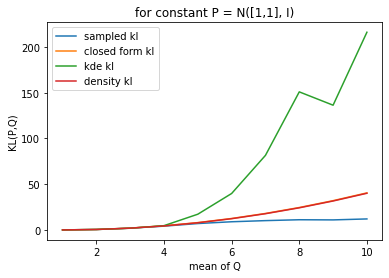

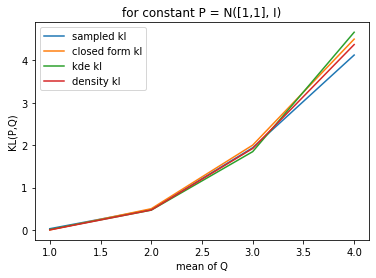

IndexError: Inconsistent shape between the condition and the input (got (25600, 1) and (25600,))

In [23]:
# testing out KL & entropy
np.random.seed(23) 
num_checks = 10

# KL preallocate
sampled_kl = np.empty((num_checks,))
closed_form_kl = np.empty((num_checks,))
kde_kl = np.empty((num_checks,))
density_kl = np.empty((num_checks,))

# entropy pre-allocate

for i in np.arange(1, num_checks+1):
    m0 = np.array([1,1])
    m1 = np.array([i,1])

    S0 = np.identity(2)
    S1 = np.identity(2)

    dist1 = np.random.multivariate_normal(m0, S0, 20000)
    dist2 = np.random.multivariate_normal(m1, S1, 20000)

    xx, yy = np.mgrid[-1:15:.1, -1:15:.1]
    pos = np.vstack([xx.ravel(), yy.ravel()])

    x1 = dist1[:,0]; y1 = dist1[:,1]; values1 = np.vstack([x1,y1]);
    x2 = dist2[:,0]; y2 = dist2[:,1]; values2 = np.vstack([x2,y2]);

    kernel1 = gaussian_kde(values1); kde_density1 = kernel1(pos)
    kernel2 = gaussian_kde(values2); kde_density2 = kernel2(pos)

    pos = np.dstack((xx, yy))
    density1 = multivariate_normal(m0, S0).pdf(pos)
    density2 = multivariate_normal(m1, S1).pdf(pos)

    closed_form_kl[i-1] = kl_mvn(m0, S0, m1, S1)
    sampled_kl[i-1] = KLdivergence(dist1, dist2)
    kde_kl[i-1] = kl_divergence(kde_density1.ravel()/np.sum(kde_density1) + 1e-100, kde_density2.ravel()/np.sum(kde_density2)+ 1e-100)
    density_kl[i-1] = kl_divergence(density1.ravel()/np.sum(density1), density2.ravel()/np.sum(density2))

    # 
plt.plot(np.arange(1, num_checks+1), sampled_kl, label = 'sampled kl')
plt.plot(np.arange(1, num_checks+1), closed_form_kl, label='closed form kl')
plt.plot(np.arange(1, num_checks+1), kde_kl, label='kde kl')
plt.plot(np.arange(1, num_checks+1), density_kl, label='density kl')
plt.xlabel("mean of Q")
plt.ylabel("KL(P,Q)")
plt.title("for constant P = N([1,1], I)")

plt.axis()

plt.legend()
plt.show()

plt.plot(np.arange(1, 5), sampled_kl[0:4], label = 'sampled kl')
plt.plot(np.arange(1, 5), closed_form_kl[0:4], label='closed form kl')
plt.plot(np.arange(1, 5), kde_kl[0:4], label='kde kl')
plt.plot(np.arange(1, 5), density_kl[0:4], label='density kl')
plt.xlabel("mean of Q")
plt.ylabel("KL(P,Q)")
plt.title("for constant P = N([1,1], I)")

plt.legend()
plt.show()

Test entropy

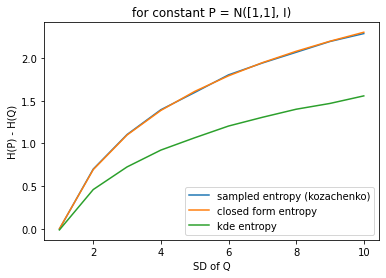

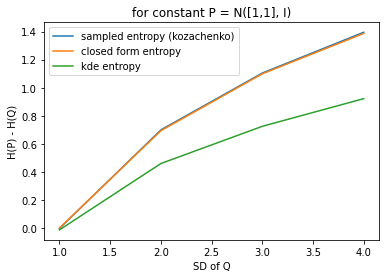

In [9]:
# testing out KL & entropy
np.random.seed(23) 
num_checks = 10

# KL preallocate
sampled_entropy = np.empty((num_checks,))
closed_form_entropy = np.empty((num_checks,))
kde_entropy = np.empty((num_checks,))
analytic_entropy = np.empty((num_checks,))

# entropy closed form defintion
entropy_mvn = lambda cov: 1 + np.log(2*np.pi) + 1/2 * np.log(np.linalg.det(cov))

for i in np.arange(1, num_checks+1):
    m0 = np.array([1,1])
    m1 = np.array([1,1])

    S0 = np.identity(2) * i
    S1 = np.identity(2) 

    dist1 = np.random.multivariate_normal(m0, S0, 20000)
    dist2 = np.random.multivariate_normal(m1, S1, 20000)

    xx, yy = np.mgrid[-1:15:.1, -1:15:.1]
    pos = np.vstack([xx.ravel(), yy.ravel()])

    x1 = dist1[:,0]; y1 = dist1[:,1]; values1 = np.vstack([x1,y1]);
    x2 = dist2[:,0]; y2 = dist2[:,1]; values2 = np.vstack([x2,y2]);

    kernel1 = gaussian_kde(values1); kde_density1 = kernel1(pos)
    kernel2 = gaussian_kde(values2); kde_density2 = kernel2(pos)

    closed_form_entropy[i-1] = entropy_mvn(S0) - entropy_mvn(S1)
    sampled_entropy[i-1] = continuous.get_h(dist1, k=5) - continuous.get_h(dist2, k=5)
    analytic_entropy[i-1] = continuous.get_h_mvn(dist1) - continuous.get_h_mvn(dist2)
    kde_entropy[i-1] = entropy(kde_density1) - entropy(kde_density2)
    # 
plt.plot(np.arange(1, num_checks+1), sampled_entropy, label = 'sampled entropy (kozachenko)')
plt.plot(np.arange(1, num_checks+1), closed_form_entropy, label='closed form entropy')
#plt.plot(np.arange(1, num_checks+1), analytic_entropy, label='analytic entropy')
plt.plot(np.arange(1, num_checks+1), kde_entropy, label='kde entropy')

plt.xlabel("SD of Q")
plt.ylabel("H(P) - H(Q)")
plt.title("for constant P = N([1,1], I)")

plt.axis()

plt.legend()
plt.show()

plt.plot(np.arange(1, 5), sampled_entropy[0:4], label = 'sampled entropy (kozachenko)')
plt.plot(np.arange(1, 5), closed_form_entropy[0:4], label='closed form entropy')
plt.plot(np.arange(1, 5), kde_entropy[0:4], label='kde entropy')

plt.xlabel("SD of Q")
plt.ylabel("H(P) - H(Q)")
plt.title("for constant P = N([1,1], I)")

plt.legend()
plt.show()

NameError: name 'sequence_length' is not defined

In [8]:
s
    # get posterior predictive for each next obs
    # post_preds = 1

    # compute KL for each hypothetical next obs
        # compute_KL(post, pre)


    # get EIG
    # EIG_stim = KLs * post_preds

    # decision rule
    if EIG_stim < EIG_env:
        sample = False
        model_LT[exemplar_num-1] = samples_from_current_stim

        # reset/increment counters
        samples_from_current_stim = 1
        exemplar_num =+ 1
    else:
        samples_from_current_stim =+ 1 
    
    total_samples =+1



NameError: name 'sequence_length' is not defined

Get the model

Generate data 

Model parameters

Action loop